# Identify stadials and interstadials from Hodel et al., 2023's data

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

data_dir = 'D:/VScode/Last_deglaciation/data'
file_path = f'{data_dir}/d18O_ZrSr.xlsx'

# Read the Excel file
df = pd.read_excel(file_path)

# Rename the columns
df.columns = ['d18O_Age', 'plank_d18O', 'empty', 'Zr_Sr_age', 'Zr_Sr']

# Drop the empty column
df.drop('empty', axis=1, inplace=True)

# Separate the columns into two dataframes
d18O = df[['d18O_Age', 'plank_d18O']]
# Drop the rows with NaN values and assign to a new DataFrame
d18O_clean = d18O.dropna()

Zr_Sr = df[['Zr_Sr_age', 'Zr_Sr']]
# Drop the rows with NaN values and assign to a new DataFrame
Zr_Sr_clean = Zr_Sr.dropna()

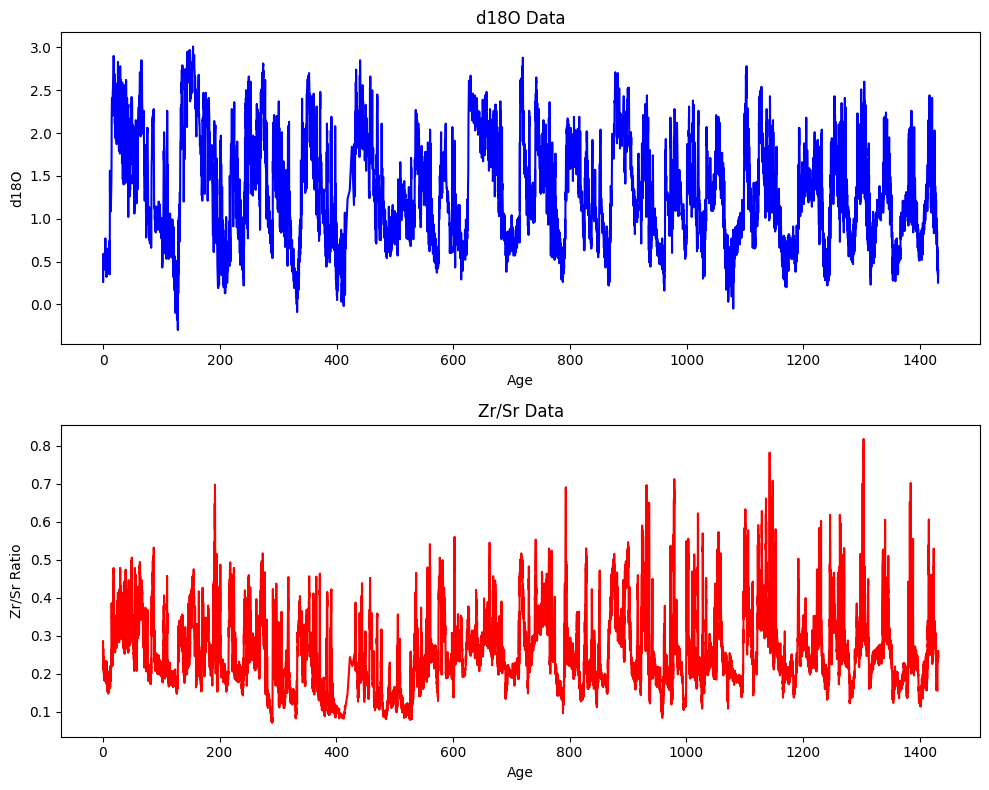

In [27]:
# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# d18O plot
ax[0].plot(d18O_clean['d18O_Age'], d18O_clean['plank_d18O'], label='d18O', color='blue')
ax[0].set_title('d18O Data')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('d18O')

# Zr_Sr plot
ax[1].plot(Zr_Sr_clean['Zr_Sr_age'], Zr_Sr_clean['Zr_Sr'], label='Zr/Sr', color='red')
ax[1].set_title('Zr/Sr Data')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Zr/Sr Ratio')

# Adjust layout
plt.tight_layout()
plt.show()

# Go through a Hi-pass filter

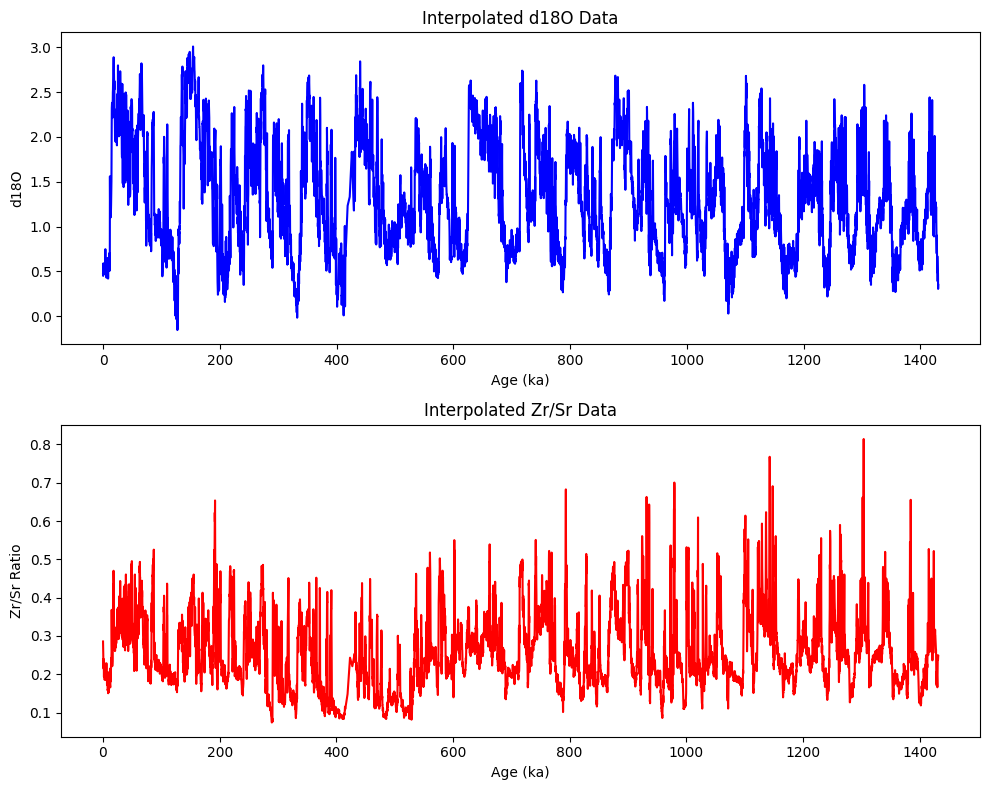

In [28]:
# interpolate the data

import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

# Create age range with 0.2ka intervals for d18O
new_age_range_d18O = np.arange(d18O['d18O_Age'].min(), d18O['d18O_Age'].max(), 0.2)

# Create age range with 0.2ka intervals for Zr/Sr
new_age_range_Zr_Sr = np.arange(Zr_Sr['Zr_Sr_age'].min(), Zr_Sr['Zr_Sr_age'].max(), 0.2)

# Interpolate d18O data
interp_d18O = interp1d(d18O['d18O_Age'], d18O['plank_d18O'], kind='linear', bounds_error=False, fill_value='extrapolate')
d18O_interp_values = interp_d18O(new_age_range_d18O)

# Interpolate Zr/Sr data
interp_Zr_Sr = interp1d(Zr_Sr['Zr_Sr_age'], Zr_Sr['Zr_Sr'], kind='linear', bounds_error=False, fill_value='extrapolate')
Zr_Sr_interp_values = interp_Zr_Sr(new_age_range_Zr_Sr)

# Store interpolated data in dataframes
df_d18O_interp = pd.DataFrame({'d18O_Age_interp': new_age_range_d18O, 'plank_d18O_interp': d18O_interp_values})
df_Zr_Sr_interp = pd.DataFrame({'Zr_Sr_age_interp': new_age_range_Zr_Sr, 'Zr_Sr_interp': Zr_Sr_interp_values})

# drop rows with NaN values
df_d18O_interp = df_d18O_interp.dropna()
df_Zr_Sr_interp = df_Zr_Sr_interp.dropna()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# d18O plot
ax[0].plot(df_d18O_interp['d18O_Age_interp'], df_d18O_interp['plank_d18O_interp'], label='d18O', color='blue')
ax[0].set_title('Interpolated d18O Data')
ax[0].set_xlabel('Age (ka)')
ax[0].set_ylabel('d18O')

# Zr/Sr plot
ax[1].plot(df_Zr_Sr_interp['Zr_Sr_age_interp'], df_Zr_Sr_interp['Zr_Sr_interp'], label='Zr/Sr', color='red')
ax[1].set_title('Interpolated Zr/Sr Data')
ax[1].set_xlabel('Age (ka)')
ax[1].set_ylabel('Zr/Sr Ratio')

# Adjust layout
plt.tight_layout()
plt.show()

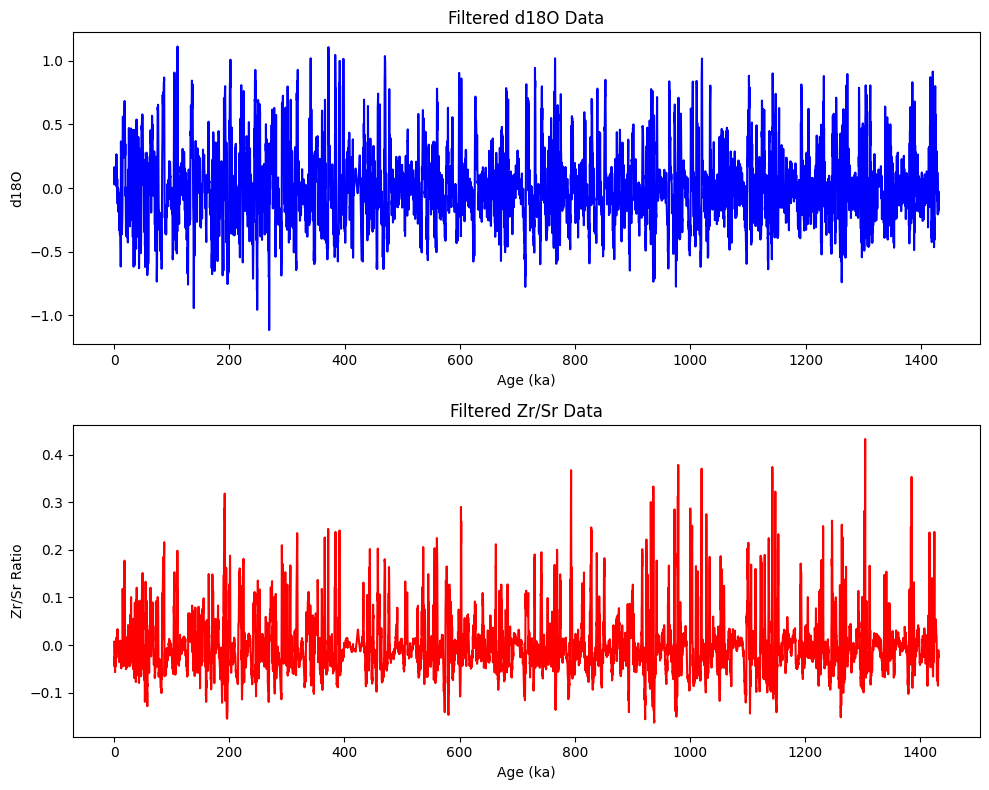

In [31]:
from scipy.signal import butter, filtfilt

# Define the Butterworth filter
def butter_highpass(cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=2):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Since our data resolution is 0.2 ka, the sampling frequency (fs) is 1/0.2 = 5 samples/ky
fs = 5.0
# Cutoff frequency is 1/20 ky = 0.05 ky^-1
cutoff = 0.05

# Apply the filter to the interpolated d18O and Zr_Sr data
df_d18O_interp['plank_d18O_filtered'] = butter_highpass_filter(df_d18O_interp['plank_d18O_interp'], cutoff, fs)
df_Zr_Sr_interp['Zr_Sr_filtered'] = butter_highpass_filter(df_Zr_Sr_interp['Zr_Sr_interp'], cutoff, fs)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# d18O plot
ax[0].plot(df_d18O_interp['d18O_Age_interp'], df_d18O_interp['plank_d18O_filtered'], label='Filtered d18O', color='blue')
ax[0].set_title('Filtered d18O Data')
ax[0].set_xlabel('Age (ka)')
ax[0].set_ylabel('d18O')

# Zr/Sr plot
ax[1].plot(df_Zr_Sr_interp['Zr_Sr_age_interp'], df_Zr_Sr_interp['Zr_Sr_filtered'], label='Filtered Zr/Sr', color='red')
ax[1].set_title('Filtered Zr/Sr Data')
ax[1].set_xlabel('Age (ka)')
ax[1].set_ylabel('Zr/Sr Ratio')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [32]:
# Calculate the standard deviations
std_d18O_filtered = df_d18O_interp['plank_d18O_filtered'].std()
std_Zr_Sr_filtered = df_Zr_Sr_interp['Zr_Sr_filtered'].std()

print(f'Standard Deviation of Filtered d18O Data: {std_d18O_filtered}')
print(f'Standard Deviation of Filtered Zr/Sr Data: {std_Zr_Sr_filtered}')



Standard Deviation of Filtered d18O Data: 0.28424913618745223
Standard Deviation of Filtered Zr/Sr Data: 0.06218560389907684


# Identify stadials and interstadials

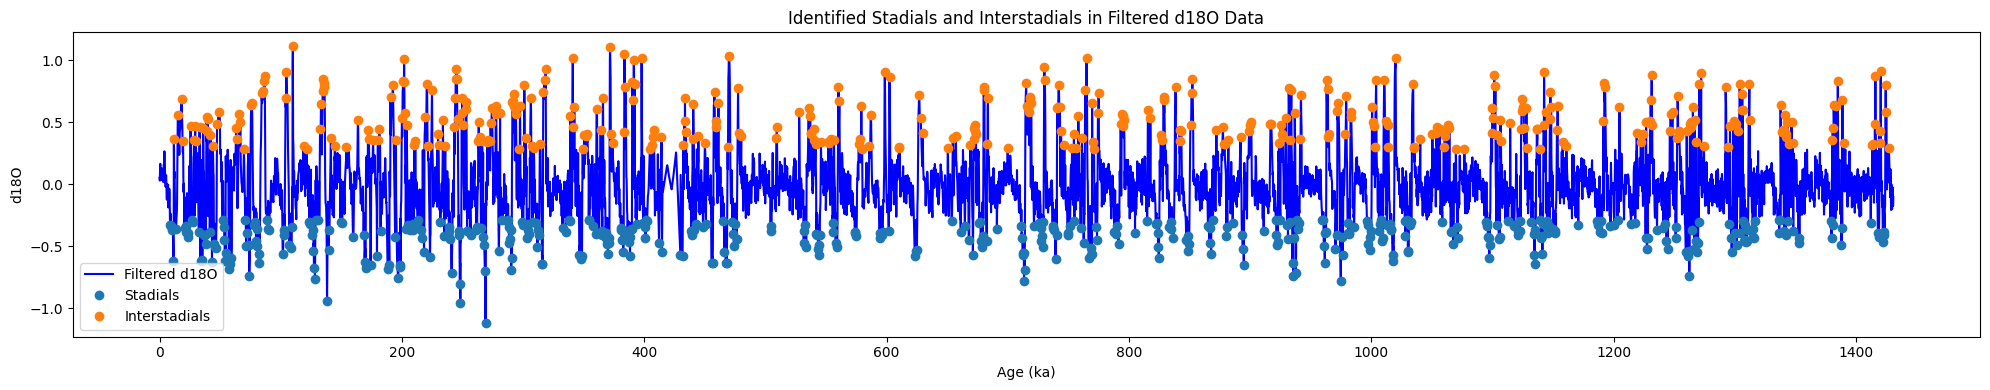

In [36]:
from scipy.signal import find_peaks

# Set parameters
multiplier = 1
threshold = multiplier * std_d18O_filtered
min_distance = 1

# Find valleys for d18O (for stadial events)
stadials, _ = find_peaks(-df_d18O_interp['plank_d18O_filtered'], height=threshold, distance=min_distance)

# Find peaks for d18O (for interstadial events)
interstadials, _ = find_peaks(df_d18O_interp['plank_d18O_filtered'], height=threshold, distance=min_distance)

# Plotting
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(df_d18O_interp['d18O_Age_interp'], df_d18O_interp['plank_d18O_filtered'], label='Filtered d18O', color='blue')
ax.plot(df_d18O_interp['d18O_Age_interp'].iloc[stadials], df_d18O_interp['plank_d18O_filtered'].iloc[stadials], "o", label='Stadials')
ax.plot(df_d18O_interp['d18O_Age_interp'].iloc[interstadials], df_d18O_interp['plank_d18O_filtered'].iloc[interstadials], "o", label='Interstadials')
ax.set_title('Identified Stadials and Interstadials in Filtered d18O Data')
ax.set_xlabel('Age (ka)')
ax.set_ylabel('d18O')
ax.legend()

plt.tight_layout()
plt.show()



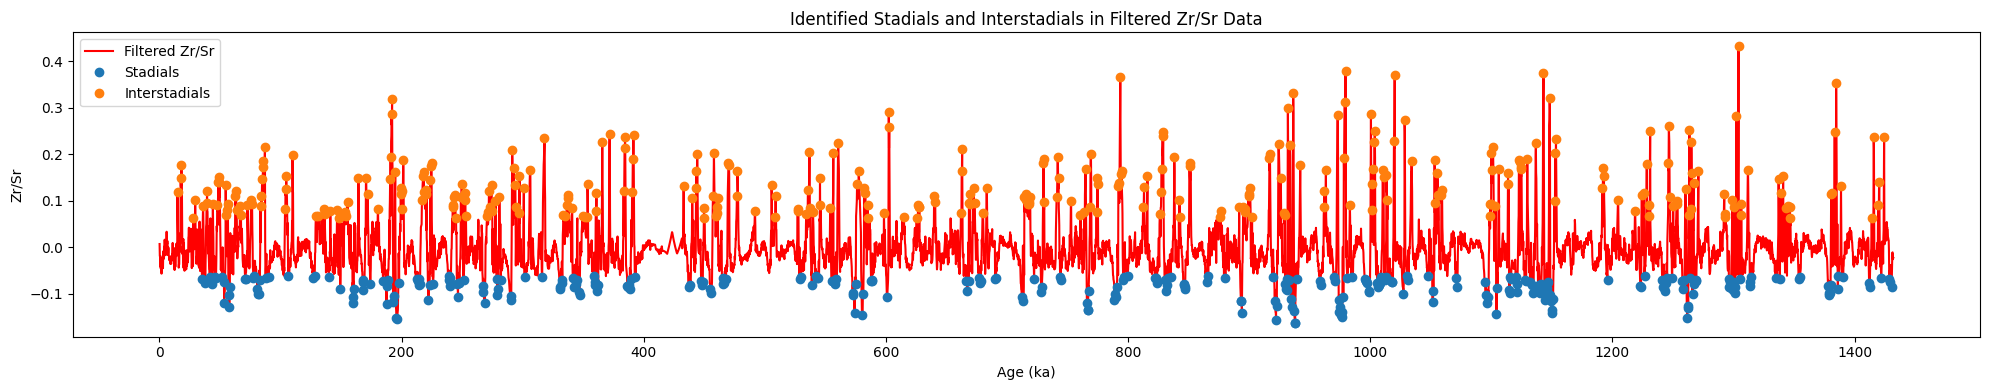

In [38]:
from scipy.signal import find_peaks

# Calculate standard deviation for the Zr_Sr filtered data
std_Zr_Sr_filtered = df_Zr_Sr_interp['Zr_Sr_filtered'].std()

# Set parameters
multiplier = 1
threshold_Zr_Sr = multiplier * std_Zr_Sr_filtered
min_distance = 1

# Find valleys for Zr_Sr (for stadial events)
stadials_Zr_Sr, _ = find_peaks(-df_Zr_Sr_interp['Zr_Sr_filtered'], height=threshold_Zr_Sr, distance=min_distance)

# Find peaks for Zr_Sr (for interstadial events)
interstadials_Zr_Sr, _ = find_peaks(df_Zr_Sr_interp['Zr_Sr_filtered'], height=threshold_Zr_Sr, distance=min_distance)

# Plotting
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(df_Zr_Sr_interp['Zr_Sr_age_interp'], df_Zr_Sr_interp['Zr_Sr_filtered'], label='Filtered Zr/Sr', color='red')
ax.plot(df_Zr_Sr_interp['Zr_Sr_age_interp'].iloc[stadials_Zr_Sr], df_Zr_Sr_interp['Zr_Sr_filtered'].iloc[stadials_Zr_Sr], "o", label='Stadials')
ax.plot(df_Zr_Sr_interp['Zr_Sr_age_interp'].iloc[interstadials_Zr_Sr], df_Zr_Sr_interp['Zr_Sr_filtered'].iloc[interstadials_Zr_Sr], "o", label='Interstadials')
ax.set_title('Identified Stadials and Interstadials in Filtered Zr/Sr Data')
ax.set_xlabel('Age (ka)')
ax.set_ylabel('Zr/Sr')
ax.legend()

plt.tight_layout()
plt.show()


In [37]:
stadials

array([  44,   48,   50,   53,   57,   67,  103,  107,  109,  117,  119,
        133,  136,  162,  169,  176,  185,  187,  191,  207,  216,  225,
        228,  231,  260,  264,  267,  269,  272,  288,  290,  296,  353,
        357,  360,  368,  370,  391,  394,  398,  401,  404,  409,  412,
        443,  446,  451,  508,  512,  515,  535,  544,  548,  618,  621,
        629,  633,  635,  637,  641,  645,  654,  691,  697,  701,  747,
        753,  800,  842,  846,  850,  871,  897,  912,  941,  948,  972,
        984,  991,  994, 1016, 1023, 1033, 1035, 1044, 1047, 1064, 1067,
       1079, 1084, 1091, 1116, 1159, 1175, 1194, 1196, 1200, 1205, 1234,
       1236, 1239, 1241, 1269, 1283, 1306, 1310, 1326, 1336, 1338, 1342,
       1345, 1400, 1413, 1435, 1437, 1440, 1443, 1445, 1449, 1451, 1453,
       1496, 1500, 1516, 1519, 1522, 1524, 1539, 1554, 1559, 1561, 1564,
       1578, 1580, 1663, 1676, 1689, 1693, 1732, 1737, 1743, 1771, 1773,
       1789, 1800, 1811, 1825, 1827, 1840, 1842, 18

In [29]:
df_d18O_interp

,d18O_Age_interp,plank_d18O_interp
0,0.0,0.470000
1,0.2,0.450000
2,0.4,0.553333
3,0.6,0.590000
4,0.8,0.476000
...,...,...
7150,1430.0,0.480000
7151,1430.2,0.480000
7152,1430.4,0.480000
7153,1430.6,0.305000


In [30]:
df_Zr_Sr_interp

,Zr_Sr_age_interp,Zr_Sr_interp
0,0.13081,0.285660
1,0.33081,0.256134
2,0.53081,0.252219
3,0.73081,0.226158
4,0.93081,0.240313
...,...,...
7155,1431.13081,0.246068
7156,1431.33081,0.249622
7157,1431.53081,0.237710
7158,1431.73081,0.242370
